In [ ]:
#importing the libraries
import torch
from pathlib import Path
import gzip, pickle
from torch import nn
from torch import tensor
from torch.utils.data import DataLoader
from torch import optim
import requests
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import torch.nn.utils.prune as prune
from math import ceil
from torch.autograd import Variable
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print( device)

cuda:0


#### Loading the dataset

In [ ]:
import torchvision

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/ml project/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
test_dataset =torchvision.datasets.FashionMNIST('/content/drive/MyDrive/ml project/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               
                             ]))

In [ ]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/ml project/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
train_dataset,val_dataset=torch.utils.data.dataset.random_split(train_dataset,lengths=[50000,10000],generator=torch.Generator().manual_seed(1))

In [ ]:
train_dataset.dataset[0][1]

9

In [ ]:
BATCH_SIZE=256

In [ ]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#LeNet-5 archietecture
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
    self.average1 = nn.AvgPool2d(2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.average2 = nn.AvgPool2d(2, stride=2)
    self.conv3 = nn.Conv2d(16, 120, kernel_size=4, stride=1)
    self.flatten1 = nn.Flatten()
    self.fc1 = nn.Linear(120, 82)
    self.fc2 = nn.Linear(82,10)
  def forward(self,x):
    out = x.view(-1, 1, 28, 28)
    out = torch.tanh(self.conv1(out))
    out = self.average1(out)
    out = torch.tanh(self.conv2(out))
    out = self.average2(out)
    out = torch.tanh(self.conv3(out))
    out = out.view(-1, out.shape[1])
    out = torch.tanh(self.fc1(out))
    out = F.softmax(self.fc2(out),dim=1)
    return out

In [ ]:
model=Network()

In [ ]:
model.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (average1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (average2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=10, bias=True)
)

In [ ]:
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.7)

In [ ]:
crieteria=nn.CrossEntropyLoss()

In [ ]:
n_epochs=100
train_loss=[]
val_loss=[]
train_accuracy=[]
val_accuracy=[]

In [ ]:
from torch.autograd import Variable

#### Training baseline model

In [ ]:
model.train()
for epoch in range(n_epochs):
  tr_loss=0
  vl_loss=0
  print(f"-----------EPOCH {epoch} ------------------ ")
  correct=0
  for images, labels in train_loader:
    #print(images.shape,len(labels))
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    train = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(train)
   # print(outputs.shape)
    loss = crieteria(outputs, labels)
    tr_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
    loss.backward()
    optimizer.step()
  train_loss.append(tr_loss/len(train_dataset))
  train_accuracy.append(correct/len(train_dataset))
  print(f"Training loss :{tr_loss/len(train_dataset)}")
  print(f"Training Accuracy :{correct/len(train_dataset)}")
  correct=0
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    val = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(val)
    loss = crieteria(outputs, labels)
    vl_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
  val_loss.append(vl_loss/len(val_dataset))
  val_accuracy.append(correct/len(val_dataset))
  print(f"Validation loss :{vl_loss/len(val_dataset)}")
  print(f"Validation Accuracy :{correct/len(val_dataset)}")
  

-----------EPOCH 0 ------------------ 
Training loss :2.2606210261535646
Training Accuracy :0.1750199943780899
Validation loss :2.066728182411194
Validation Accuracy :0.3971000015735626
-----------EPOCH 1 ------------------ 
Training loss :1.8794935385894775
Training Accuracy :0.6176999807357788
Validation loss :1.7668575136184692
Validation Accuracy :0.7226999998092651
-----------EPOCH 2 ------------------ 
Training loss :1.738651905860901
Training Accuracy :0.7410399913787842
Validation loss :1.7149710748672486
Validation Accuracy :0.7567999958992004
-----------EPOCH 3 ------------------ 
Training loss :1.7033669500350952
Training Accuracy :0.7679599523544312
Validation loss :1.6974736894607545
Validation Accuracy :0.7736999988555908
-----------EPOCH 4 ------------------ 
Training loss :1.684995242614746
Training Accuracy :0.784339964389801
Validation loss :1.6786828147888184
Validation Accuracy :0.7906000018119812
-----------EPOCH 5 ------------------ 
Training loss :1.6721498733520

In [ ]:
model(test_dataset[100][0].view(1,1,28,28).to(device))

tensor([[3.0256e-09, 1.0799e-12, 7.3252e-12, 7.8732e-15, 3.2393e-10, 1.5599e-08,
         1.0000e+00, 1.4372e-17, 2.1705e-10, 1.1894e-14]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
#Testing baseline
tloss=0
correct=0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    val = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(val)
    loss = crieteria(outputs, labels)
    tloss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
print(f"Test loss :{tloss/len(test_dataset)}")
print(f"Test Accuracy :{correct/len(test_dataset)}")

Test loss :1.5707487842559815
Test Accuracy :0.8896999955177307


In [ ]:
torch.save(model,"/content/drive/MyDrive/ml project/model1_fas")

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [ ]:
pytorch_total_params

44164

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
model.train()

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (average1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (average2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=10, bias=True)
)

In [ ]:
optimizer.zero_grad()

#### Magnitude based pruning without retraining 

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model1_fas")

In [ ]:
acc_wr=[0.8896999955177307]
sparsity_wr=[1]
for i in range(20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )

  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity_wr.append((1-0.2)**(i+1))
  acc_wr.append(correct/len(test_dataset))

Test loss :1.5695224208831786
Test Accuracy :0.8912000060081482
Test loss :1.5719544815063478
Test Accuracy :0.8880999684333801
Test loss :1.578007314300537
Test Accuracy :0.8827999830245972
Test loss :1.5822379123687744
Test Accuracy :0.8779000043869019
Test loss :1.5907931869506835
Test Accuracy :0.871399998664856
Test loss :1.6102499485015869
Test Accuracy :0.8515999913215637
Test loss :1.6251988744735717
Test Accuracy :0.837399959564209
Test loss :1.6698698499679565
Test Accuracy :0.7978999614715576
Test loss :1.7661153009414672
Test Accuracy :0.703000009059906
Test loss :1.8523760080337524
Test Accuracy :0.617900013923645
Test loss :1.9573596134185791
Test Accuracy :0.508899986743927
Test loss :2.0352761749267576
Test Accuracy :0.41589999198913574
Test loss :2.160883317184448
Test Accuracy :0.28380000591278076
Test loss :2.261171620941162
Test Accuracy :0.16759999096393585
Test loss :2.2596914867401123
Test Accuracy :0.1622999906539917
Test loss :2.2768391487121584
Test Accuracy :

In [ ]:
import matplotlib.pyplot as plt

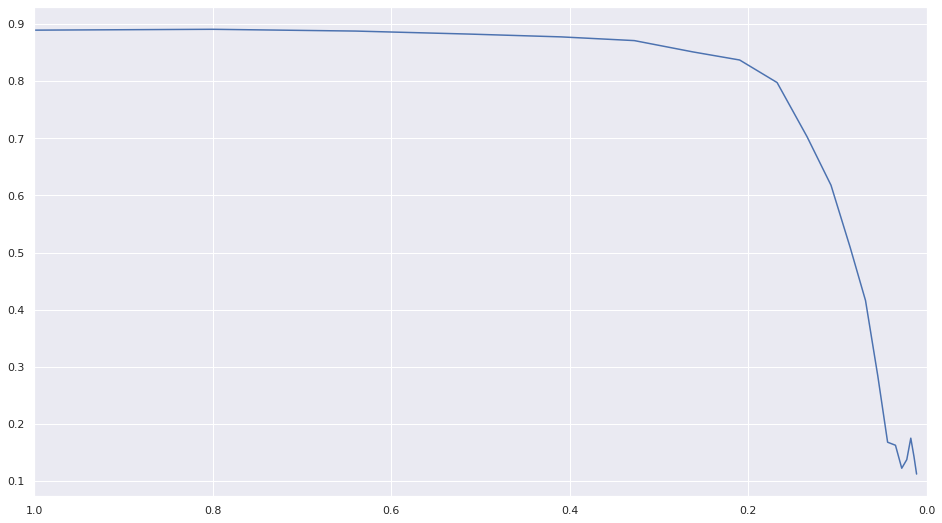

In [ ]:
#plotting sparsity vs accuracy 
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.plot(sparsity_wr,acc_wr)

#### Magnitude based untructured pruning with retraining

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model1_fas")

In [ ]:
acc=[0.8896999955177307]
sparsity=[1]
for i in range(20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )
  n_epochs=10
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  learning_rate = 0.01
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")


  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity.append((1-0.2)**(i+1))
  acc.append(correct/len(test_dataset))

-----------EPOCH 0 ------------------ 
Training loss :1.5073880262756347
Training Accuracy :0.9547199606895447
Validation loss :1.564076488494873
Validation Accuracy :0.8967999815940857
-----------EPOCH 1 ------------------ 
Training loss :1.5058715196990966
Training Accuracy :0.9560999870300293
Validation loss :1.5638316165924073
Validation Accuracy :0.897599995136261
-----------EPOCH 2 ------------------ 
Training loss :1.5054880042266845
Training Accuracy :0.9563199877738953
Validation loss :1.5637301959991454
Validation Accuracy :0.8974999785423279
-----------EPOCH 3 ------------------ 
Training loss :1.5052196309661865
Training Accuracy :0.956559956073761
Validation loss :1.5633393642425537
Validation Accuracy :0.8984999656677246
-----------EPOCH 4 ------------------ 
Training loss :1.5050400049591064
Training Accuracy :0.9566599726676941
Validation loss :1.5634446647644042
Validation Accuracy :0.8978999853134155
-----------EPOCH 5 ------------------ 
Training loss :1.504889524879

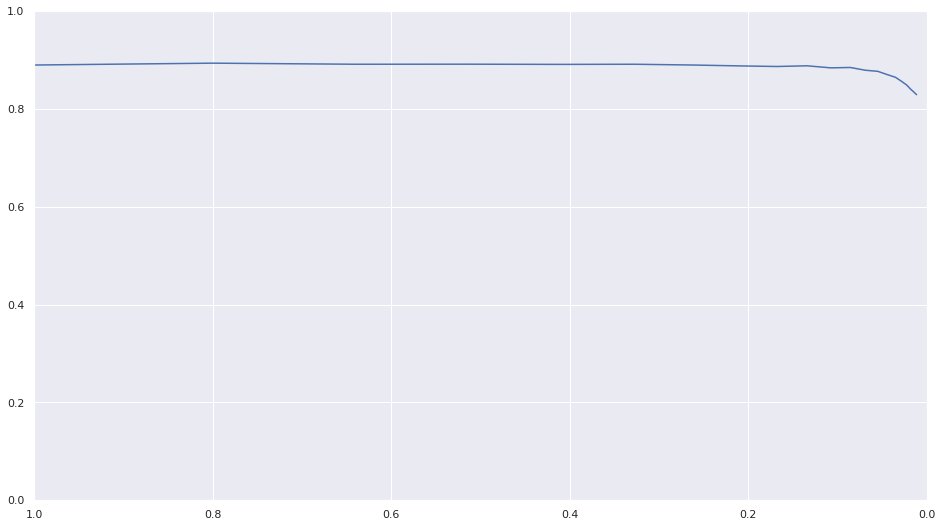

In [ ]:
#plot of sparsity vs accuracy
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,1)
plt.plot(sparsity,acc)


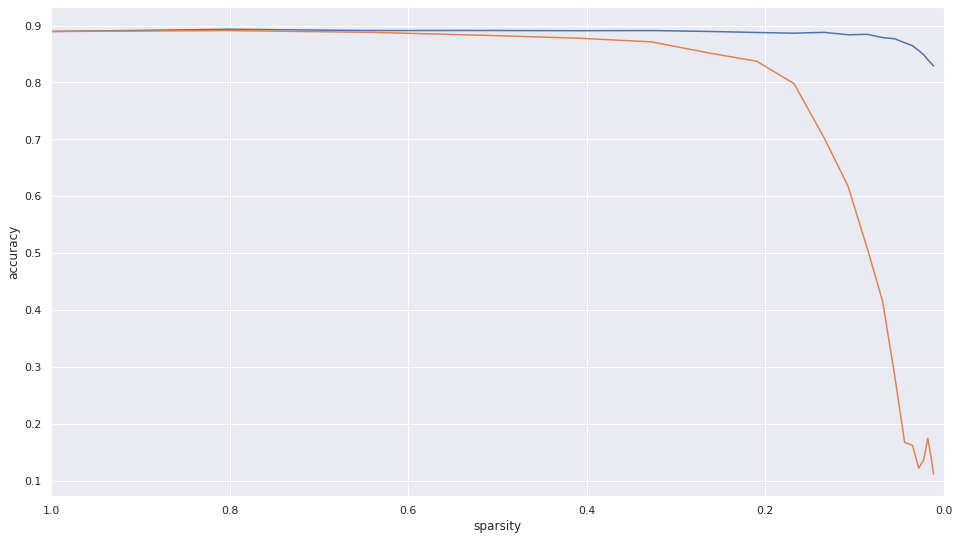

In [ ]:
#comparing sparsity vs accuracy with and without retraining
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.xlabel("sparsity")
plt.ylabel("accuracy")


plt.plot(sparsity,acc)
plt.plot(sparsity_wr,acc_wr)

In [ ]:
sparsity_wr,acc_wr

([1,
  0.8,
  0.6400000000000001,
  0.5120000000000001,
  0.4096000000000001,
  0.3276800000000001,
  0.2621440000000001,
  0.20971520000000007,
  0.1677721600000001,
  0.13421772800000006,
  0.10737418240000006,
  0.08589934592000005,
  0.06871947673600004,
  0.054975581388800036,
  0.043980465111040035,
  0.03518437208883203,
  0.028147497671065624,
  0.022517998136852502,
  0.018014398509482003,
  0.014411518807585602,
  0.011529215046068483],
 [0.8896999955177307,
  tensor(0.8912, device='cuda:0'),
  tensor(0.8881, device='cuda:0'),
  tensor(0.8828, device='cuda:0'),
  tensor(0.8779, device='cuda:0'),
  tensor(0.8714, device='cuda:0'),
  tensor(0.8516, device='cuda:0'),
  tensor(0.8374, device='cuda:0'),
  tensor(0.7979, device='cuda:0'),
  tensor(0.7030, device='cuda:0'),
  tensor(0.6179, device='cuda:0'),
  tensor(0.5089, device='cuda:0'),
  tensor(0.4159, device='cuda:0'),
  tensor(0.2838, device='cuda:0'),
  tensor(0.1676, device='cuda:0'),
  tensor(0.1623, device='cuda:0'),
  

In [ ]:
sparsity,acc

([1,
  0.8,
  0.6400000000000001,
  0.5120000000000001,
  0.4096000000000001,
  0.3276800000000001,
  0.2621440000000001,
  0.20971520000000007,
  0.1677721600000001,
  0.13421772800000006,
  0.10737418240000006,
  0.08589934592000005,
  0.06871947673600004,
  0.054975581388800036,
  0.043980465111040035,
  0.03518437208883203,
  0.028147497671065624,
  0.022517998136852502,
  0.018014398509482003,
  0.014411518807585602,
  0.011529215046068483],
 [0.8896999955177307,
  tensor(0.8935, device='cuda:0'),
  tensor(0.8913, device='cuda:0'),
  tensor(0.8914, device='cuda:0'),
  tensor(0.8910, device='cuda:0'),
  tensor(0.8913, device='cuda:0'),
  tensor(0.8897, device='cuda:0'),
  tensor(0.8879, device='cuda:0'),
  tensor(0.8867, device='cuda:0'),
  tensor(0.8881, device='cuda:0'),
  tensor(0.8839, device='cuda:0'),
  tensor(0.8847, device='cuda:0'),
  tensor(0.8790, device='cuda:0'),
  tensor(0.8768, device='cuda:0'),
  tensor(0.8699, device='cuda:0'),
  tensor(0.8646, device='cuda:0'),
  

#### L1 norm based structured pruning without retraining

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model1_fas")

In [ ]:
acc_wr=[0.8896999955177307]
sparsity_wr=[1]
for i in range(20):
  #prune.ln_structured(model.conv1,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv2,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv3,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.fc1,'weight',amount=0.2,dim=0,n=1)
  #prune.ln_structured(model.fc2,'weight',amount=0.2,dim=0,n=1)
  #computing no of removed parameters
  no_removed=0
  for i in range(model.conv2.state_dict()['weight_mask'].shape[0]):
    if model.conv2.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv2.state_dict()['weight_mask'][i])
  for i in range(model.conv3.state_dict()['weight_mask'].shape[0]):
    if model.conv3.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv3.state_dict()['weight_mask'][i])
  for i in range(model.fc1.state_dict()['weight_mask'].shape[0]):
    if model.fc1.state_dict()['weight_mask'][i][0]==0:
      no_removed+=torch.numel(model.fc1.state_dict()['weight_mask'][i])
  
  print(f"Sparsity= : {1-(no_removed/44164)}")
  
  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity_wr.append(1-(no_removed/44164))
  acc_wr.append(correct/len(test_dataset))

Sparsity= : 0.8072185490444705
Test loss :1.675094066810608
Test Accuracy :0.7907999753952026
Sparsity= : 0.651571415632642
Test loss :1.9541144653320313
Test Accuracy :0.5059999823570251
Sparsity= : 0.5279413096639798
Test loss :2.14024631729126
Test Accuracy :0.30809998512268066
Sparsity= : 0.4298523684448873
Test loss :2.2183764430999755
Test Accuracy :0.22909998893737793
Sparsity= : 0.34947015668870574
Test loss :2.2493384590148926
Test Accuracy :0.1973000019788742
Sparsity= : 0.28611538809890413
Test loss :2.3262636711120606
Test Accuracy :0.12409999966621399
Sparsity= : 0.23707091748935782
Test loss :2.349740808105469
Test Accuracy :0.10300000011920929
Sparsity= : 0.19382302327687706
Test loss :2.3464868816375732
Test Accuracy :0.09269999712705612
Sparsity= : 0.16248528213024183
Test loss :2.3392502464294433
Test Accuracy :0.09839999675750732
Sparsity= : 0.13966126256679645
Test loss :2.331182717514038
Test Accuracy :0.09129999577999115
Sparsity= : 0.11683724300335119
Test loss :

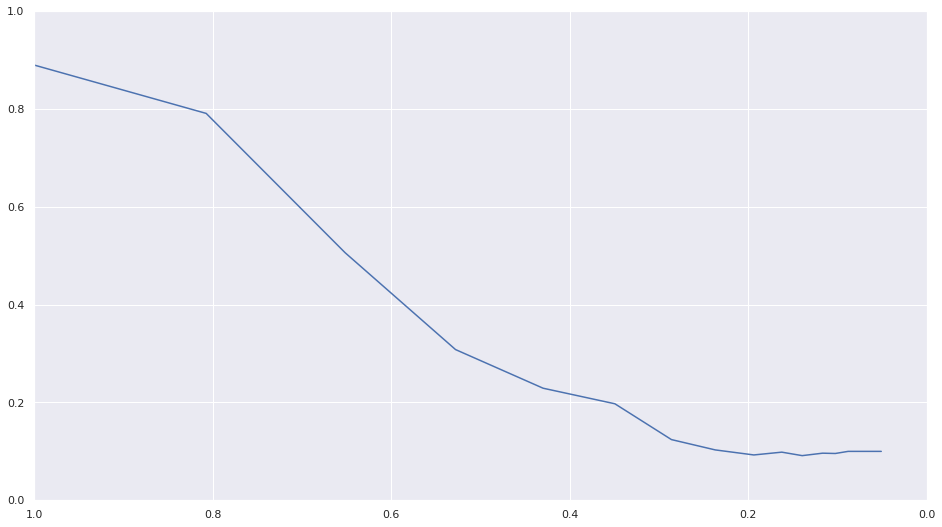

In [ ]:
#plotting sparsity vs accuracy
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,1)
plt.plot(sparsity_wr,acc_wr)

#### L1 norm based structured pruning with retraining

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model1_fas")

In [ ]:
acc=[0.8896999955177307]
sparsity=[1]
for i in range(20):
  #prune.ln_structured(model.conv1,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv2,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.conv3,'weight',amount=0.2,dim=0,n=1)
  prune.ln_structured(model.fc1,'weight',amount=0.2,dim=0,n=1)
  #prune.ln_structured(model.fc2,'weight',amount=0.2,dim=0,n=1)
  no_removed=0
  for i in range(model.conv2.state_dict()['weight_mask'].shape[0]):
    if model.conv2.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv2.state_dict()['weight_mask'][i])
  for i in range(model.conv3.state_dict()['weight_mask'].shape[0]):
    if model.conv3.state_dict()['weight_mask'][i][0][0][0]==0:
      no_removed+=torch.numel(model.conv3.state_dict()['weight_mask'][i])
  for i in range(model.fc1.state_dict()['weight_mask'].shape[0]):
    if model.fc1.state_dict()['weight_mask'][i][0]==0:
      no_removed+=torch.numel(model.fc1.state_dict()['weight_mask'][i])
  
  print(f"Sparsity= : {1-(no_removed/44164)}")
  model.conv2.state_dict()['weight_mask']
  n_epochs=12
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  learning_rate = 0.01
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")


  model.eval()
  tloss=0
  correct=0
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      tloss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
  print(f"Test loss :{tloss/len(test_dataset)}")
  print(f"Test Accuracy :{correct/len(test_dataset)}")
  sparsity.append(1-(no_removed/44164))
  acc.append(correct/len(test_dataset))

Sparsity= : 0.8072185490444705
-----------EPOCH 0 ------------------ 
Training loss :1.5638346886825563
Training Accuracy :0.9016599655151367
Validation loss :1.5820186803817748
Validation Accuracy :0.8810999989509583
-----------EPOCH 1 ------------------ 
Training loss :1.5396437678909303
Training Accuracy :0.9241799712181091
Validation loss :1.5754200410842896
Validation Accuracy :0.8869999647140503
-----------EPOCH 2 ------------------ 
Training loss :1.5325206251907348
Training Accuracy :0.9318199753761292
Validation loss :1.572770984840393
Validation Accuracy :0.8894999623298645
-----------EPOCH 3 ------------------ 
Training loss :1.5282317353439332
Training Accuracy :0.9358599781990051
Validation loss :1.5713110046386718
Validation Accuracy :0.8902999758720398
-----------EPOCH 4 ------------------ 
Training loss :1.5255624327468873
Training Accuracy :0.9386799931526184
Validation loss :1.5703036165237427
Validation Accuracy :0.8912000060081482
-----------EPOCH 5 ----------------

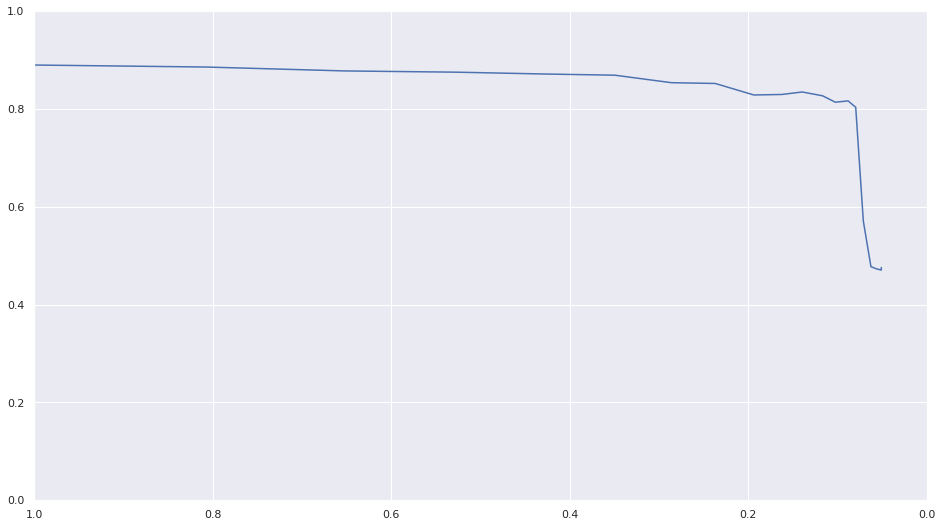

In [ ]:
#plotting sparsity vs accuracy
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,1)
plt.plot(sparsity,acc)

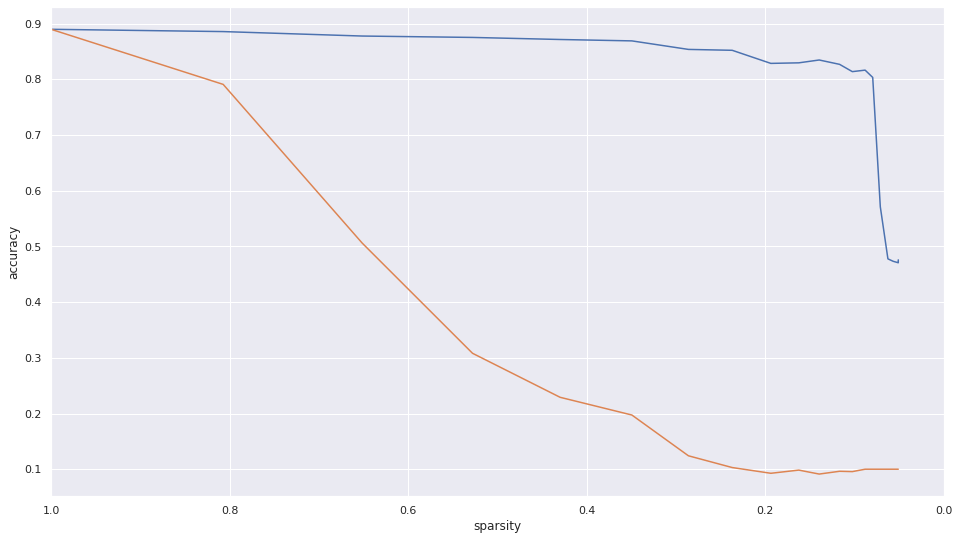

In [ ]:
#comparing the method with and without retraining
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.xlabel("sparsity")
plt.ylabel("accuracy")


plt.plot(sparsity,acc)
plt.plot(sparsity_wr,acc_wr)

In [ ]:
sparsity_wr,acc_wr

([1,
  0.8072185490444705,
  0.651571415632642,
  0.5279413096639798,
  0.4298523684448873,
  0.34947015668870574,
  0.28611538809890413,
  0.23707091748935782,
  0.19382302327687706,
  0.16248528213024183,
  0.13966126256679645,
  0.11683724300335119,
  0.10252694502309578,
  0.08821664704284027,
  0.07970292545965041,
  0.07118920387646044,
  0.06267548229327058,
  0.056878905896205034,
  0.0510823294991396,
  0.0510823294991396,
  0.0510823294991396],
 [0.8896999955177307,
  tensor(0.7908, device='cuda:0'),
  tensor(0.5060, device='cuda:0'),
  tensor(0.3081, device='cuda:0'),
  tensor(0.2291, device='cuda:0'),
  tensor(0.1973, device='cuda:0'),
  tensor(0.1241, device='cuda:0'),
  tensor(0.1030, device='cuda:0'),
  tensor(0.0927, device='cuda:0'),
  tensor(0.0984, device='cuda:0'),
  tensor(0.0913, device='cuda:0'),
  tensor(0.0963, device='cuda:0'),
  tensor(0.0957, device='cuda:0'),
  tensor(0.1000, device='cuda:0'),
  tensor(0.1000, device='cuda:0'),
  tensor(0.1000, device='cuda

In [ ]:
sparsity,acc

([1,
  0.8072185490444705,
  0.651571415632642,
  0.5279413096639798,
  0.4298523684448873,
  0.34947015668870574,
  0.28611538809890413,
  0.23707091748935782,
  0.19382302327687706,
  0.16248528213024183,
  0.13966126256679645,
  0.11683724300335119,
  0.10252694502309578,
  0.08821664704284027,
  0.07970292545965041,
  0.07118920387646044,
  0.06267548229327058,
  0.056878905896205034,
  0.0510823294991396,
  0.0510823294991396,
  0.0510823294991396],
 [0.8896999955177307,
  tensor(0.8856, device='cuda:0'),
  tensor(0.8776, device='cuda:0'),
  tensor(0.8751, device='cuda:0'),
  tensor(0.8714, device='cuda:0'),
  tensor(0.8689, device='cuda:0'),
  tensor(0.8536, device='cuda:0'),
  tensor(0.8520, device='cuda:0'),
  tensor(0.8285, device='cuda:0'),
  tensor(0.8295, device='cuda:0'),
  tensor(0.8346, device='cuda:0'),
  tensor(0.8268, device='cuda:0'),
  tensor(0.8137, device='cuda:0'),
  tensor(0.8164, device='cuda:0'),
  tensor(0.8033, device='cuda:0'),
  tensor(0.5710, device='cuda

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/model1_fas")

#### Applying lottery ticket based method

In [ ]:
model = Network()

In [ ]:
model.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (average1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (average2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=120, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=10, bias=True)
)

In [ ]:
init_weights=model

In [ ]:
#saving initializations for retraining
torch.save(init_weights,"/content/drive/MyDrive/ml project/fashion_lotteryinit")

In [ ]:
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
crieteria=nn.CrossEntropyLoss()

In [ ]:
best_acc=0
early_stop=0
n_epochs=60
train_loss=[]
val_loss=[]
train_accuracy=[]
val_accuracy=[]

In [ ]:
#training and saving early stopping
model.train()
for epoch in range(n_epochs):
  tr_loss=0
  vl_loss=0
  print(f"-----------EPOCH {epoch} ------------------ ")
  correct=0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    train = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(train)
    loss = crieteria(outputs, labels)
    tr_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
    loss.backward()
    optimizer.step()
  train_loss.append(tr_loss/len(train_dataset))
  train_accuracy.append(correct/len(train_dataset))
  print(f"Training loss :{tr_loss/len(train_dataset)}")
  print(f"Training Accuracy :{correct/len(train_dataset)}")
  correct=0
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    val = Variable(images.view(len(images), 1, 28, 28))
    labels = Variable(labels)
    outputs = model(val)
    loss = crieteria(outputs, labels)
    vl_loss+=loss.item()*len(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum()
  val_loss.append(vl_loss/len(val_dataset))
  val_accuracy.append(correct/len(val_dataset))
  print(f"Validation loss :{vl_loss/len(val_dataset)}")
  print(f"Validation Accuracy :{correct/len(val_dataset)}")
  if correct/len(val_dataset) > best_acc:
    best_acc=correct/len(val_dataset)
    early_stop=epoch
    torch.save(model,"/content/drive/MyDrive/ml project/fashion_lotterytrain")

-----------EPOCH 0 ------------------ 
Training loss :2.0092479375457764
Training Accuracy :0.48677998781204224
Validation loss :1.7469022062301636
Validation Accuracy :0.7235999703407288
-----------EPOCH 1 ------------------ 
Training loss :1.7175901782989502
Training Accuracy :0.7501800060272217
Validation loss :1.6880689916610718
Validation Accuracy :0.7770000100135803
-----------EPOCH 2 ------------------ 
Training loss :1.6739047386932373
Training Accuracy :0.7923199534416199
Validation loss :1.659077264213562
Validation Accuracy :0.8062999844551086
-----------EPOCH 3 ------------------ 
Training loss :1.6466971934509278
Training Accuracy :0.8181799650192261
Validation loss :1.6423980323791505
Validation Accuracy :0.8226000070571899
-----------EPOCH 4 ------------------ 
Training loss :1.6289335662460327
Training Accuracy :0.8356399536132812
Validation loss :1.624289900779724
Validation Accuracy :0.839199960231781
-----------EPOCH 5 ------------------ 
Training loss :1.62045873847

In [ ]:
early_stop,best_acc.cpu().numpy()

(52, array(0.8971, dtype=float32))

In [ ]:
#loading the initial weights for reinitialization while pruning
init_weights=torch.load("/content/drive/MyDrive/ml project/fashion_lotteryinit")

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/fashion_lotterytrain")

In [ ]:
from torch.nn.utils import prune

In [ ]:
#applying the magnitude based pruning with lottery ticket based initializations
sparsity=[1]
best_acc_list=[0.8971]
early_stop_list=[52]
for i in range(20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )
  #reloading from init weights
  sd=model.conv1.state_dict()
  sd["bias"]=init_weights.conv1.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv1.state_dict()['weight']
  model.conv1.load_state_dict(sd)

  sd=model.conv2.state_dict()
  sd["bias"]=init_weights.conv2.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv2.state_dict()['weight']
  model.conv2.load_state_dict(sd)

  sd=model.conv3.state_dict()
  sd["bias"]=init_weights.conv3.state_dict()['bias']
  sd["weight_orig"]=init_weights.conv3.state_dict()['weight']
  model.conv3.load_state_dict(sd)

  sd=model.fc1.state_dict()
  sd["bias"]=init_weights.fc1.state_dict()['bias']
  sd["weight_orig"]=init_weights.fc1.state_dict()['weight']
  model.fc1.load_state_dict(sd)

  sd=model.fc2.state_dict()
  sd["bias"]=init_weights.fc2.state_dict()['bias']
  sd["weight_orig"]=init_weights.fc2.state_dict()['weight']
  model.fc2.load_state_dict(sd)


  print(f"Sparsity={(1-0.2)**(i+1)}")
  
  learning_rate = 0.1
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  crieteria=nn.CrossEntropyLoss()
  best_acc=0
  early_stop=0
  n_epochs=60
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")
    if correct/len(val_dataset) > best_acc:
      best_acc=correct/len(val_dataset)
      early_stop=epoch
  best_acc_list.append(best_acc)
  early_stop_list.append(early_stop)
  sparsity.append((1-0.2)**(i+1))

Streaming output truncated to the last 5000 lines.
Training loss :1.5451351054763793
Training Accuracy :0.9180600047111511
Validation loss :1.5719850458145141
Validation Accuracy :0.8887999653816223
-----------EPOCH 24 ------------------ 
Training loss :1.5451307925415039
Training Accuracy :0.9180399775505066
Validation loss :1.5690555364608765
Validation Accuracy :0.8928999900817871
-----------EPOCH 25 ------------------ 
Training loss :1.5422625478744507
Training Accuracy :0.9207800030708313
Validation loss :1.5707945922851563
Validation Accuracy :0.8906999826431274
-----------EPOCH 26 ------------------ 
Training loss :1.54071154296875
Training Accuracy :0.922819972038269
Validation loss :1.5664227119445802
Validation Accuracy :0.8955000042915344
-----------EPOCH 27 ------------------ 
Training loss :1.542291462173462
Training Accuracy :0.9210399985313416
Validation loss :1.56792975730896
Validation Accuracy :0.8938999772071838
-----------EPOCH 28 ------------------ 
Training loss :

In [ ]:
sparsity,best_acc_list,early_stop_list

([1,
  0.8,
  0.6400000000000001,
  0.5120000000000001,
  0.4096000000000001,
  0.3276800000000001,
  0.2621440000000001,
  0.20971520000000007,
  0.1677721600000001,
  0.13421772800000006,
  0.10737418240000006,
  0.08589934592000005,
  0.06871947673600004,
  0.054975581388800036,
  0.043980465111040035,
  0.03518437208883203,
  0.028147497671065624,
  0.022517998136852502,
  0.018014398509482003,
  0.014411518807585602,
  0.011529215046068483],
 [0.8971,
  tensor(0.8966, device='cuda:0'),
  tensor(0.8966, device='cuda:0'),
  tensor(0.8972, device='cuda:0'),
  tensor(0.8982, device='cuda:0'),
  tensor(0.8979, device='cuda:0'),
  tensor(0.8993, device='cuda:0'),
  tensor(0.9000, device='cuda:0'),
  tensor(0.8989, device='cuda:0'),
  tensor(0.8978, device='cuda:0'),
  tensor(0.8984, device='cuda:0'),
  tensor(0.8968, device='cuda:0'),
  tensor(0.8846, device='cuda:0'),
  tensor(0.8412, device='cuda:0'),
  tensor(0.8383, device='cuda:0'),
  tensor(0.8366, device='cuda:0'),
  tensor(0.834

In [ ]:
#converting values to cpu for plotting
best_acc_cpu=[0.8971]
for i in range(1,len(best_acc_list)):
  best_acc_cpu.append(best_acc_list[i].cpu())

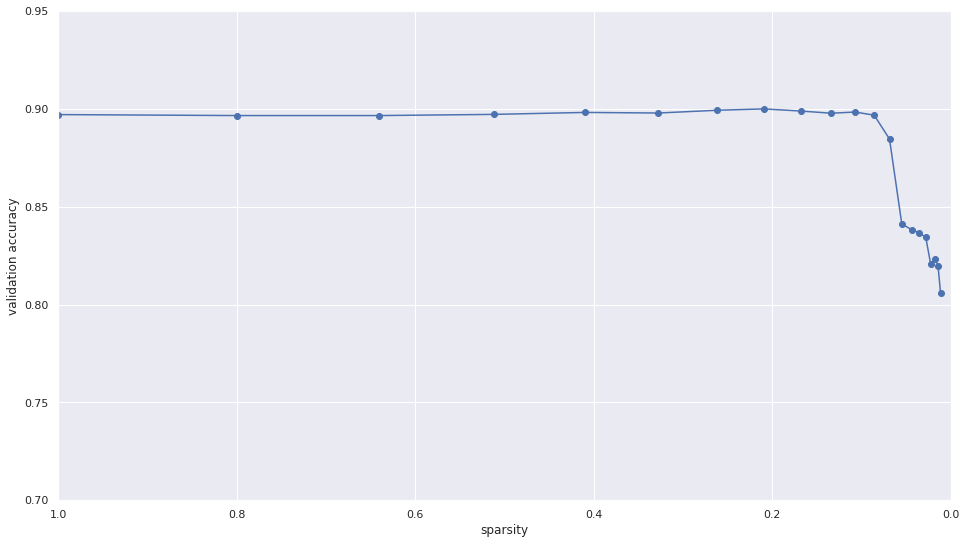

In [ ]:
#plotting sparsity vs accuracy
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0.7,0.95)
plt.xlabel("sparsity")
plt.ylabel("validation accuracy")
plt.scatter(sparsity,best_acc_cpu)
plt.plot(sparsity,best_acc_list)

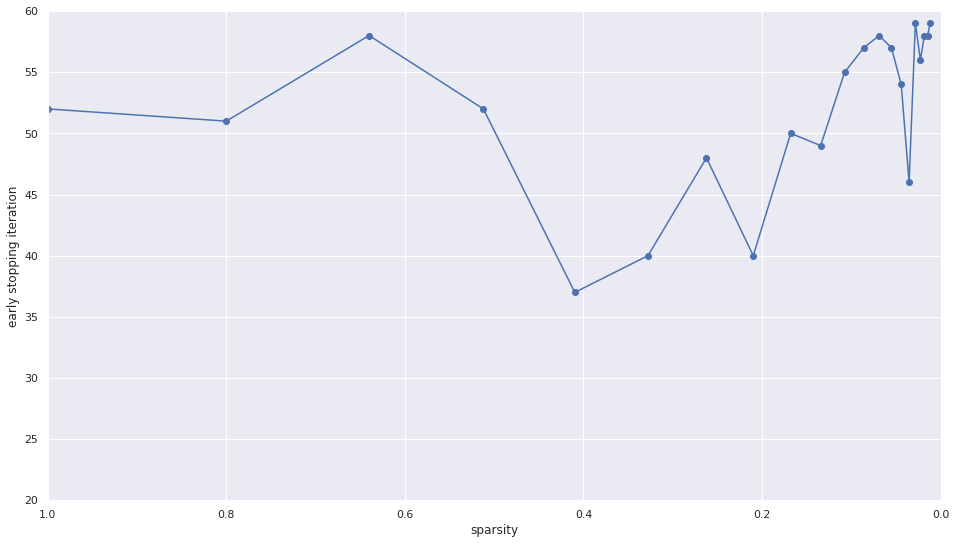

In [ ]:
#plotting early stopping 
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(20,60)
plt.xlabel("sparsity")
plt.ylabel("early stopping iteration")
plt.scatter(sparsity,early_stop_list)
plt.plot(sparsity,early_stop_list)

In [ ]:
model=torch.load("/content/drive/MyDrive/ml project/fashion_lotterytrain")

In [ ]:
#applying magnitude based pruning with random re initialization using default initialization method of pytorch
sparsity_wr=[1]
best_acc_list_wr=[0.8971]
early_stop_list_wr=[52]
for i in range(20):
  parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.conv3, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
  )

  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
  )
  #re initializing the weights using default method
  model2=Network()
  model2.to(device)
  sd=model.conv1.state_dict()
  sd["bias"]=model2.conv1.state_dict()['bias']
  sd["weight_orig"]=model2.conv1.state_dict()['weight']
  model.conv1.load_state_dict(sd)

  sd=model.conv2.state_dict()
  sd["bias"]=model2.conv2.state_dict()['bias']
  sd["weight_orig"]=model2.conv2.state_dict()['weight']
  model.conv2.load_state_dict(sd)

  sd=model.conv3.state_dict()
  sd["bias"]=model2.conv3.state_dict()['bias']
  sd["weight_orig"]=model2.conv3.state_dict()['weight']
  model.conv3.load_state_dict(sd)

  sd=model.fc1.state_dict()
  sd["bias"]=model2.fc1.state_dict()['bias']
  sd["weight_orig"]=model2.fc1.state_dict()['weight']
  model.fc1.load_state_dict(sd)

  sd=model.fc2.state_dict()
  sd["bias"]=model2.fc2.state_dict()['bias']
  sd["weight_orig"]=model2.fc2.state_dict()['weight']
  model.fc2.load_state_dict(sd)



  print(f"Sparsity={(1-0.2)**(i+1)}")
  
  learning_rate = 0.1
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
  crieteria=nn.CrossEntropyLoss()
  best_acc=0
  early_stop=0
  n_epochs=60
  train_loss=[]
  val_loss=[]
  train_accuracy=[]
  val_accuracy=[]
  model.train()
  for epoch in range(n_epochs):
    tr_loss=0
    vl_loss=0
    print(f"-----------EPOCH {epoch} ------------------ ")
    correct=0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      train = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(train)
      loss = crieteria(outputs, labels)
      tr_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
      loss.backward()
      optimizer.step()
    train_loss.append(tr_loss/len(train_dataset))
    train_accuracy.append(correct/len(train_dataset))
    print(f"Training loss :{tr_loss/len(train_dataset)}")
    print(f"Training Accuracy :{correct/len(train_dataset)}")
    correct=0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      val = Variable(images.view(len(images), 1, 28, 28))
      labels = Variable(labels)
      outputs = model(val)
      loss = crieteria(outputs, labels)
      vl_loss+=loss.item()*len(images)
      predictions = torch.max(outputs, 1)[1].to(device)
      correct += (predictions == labels).sum()
    val_loss.append(vl_loss/len(val_dataset))
    val_accuracy.append(correct/len(val_dataset))
    print(f"Validation loss :{vl_loss/len(val_dataset)}")
    print(f"Validation Accuracy :{correct/len(val_dataset)}")
    if correct/len(val_dataset) > best_acc:
      best_acc=correct/len(val_dataset)
      early_stop=epoch
  best_acc_list_wr.append(best_acc)
  early_stop_list_wr.append(early_stop)
  sparsity_wr.append((1-0.2)**(i+1))

Streaming output truncated to the last 5000 lines.
Training loss :1.622207121810913
Training Accuracy :0.8398799896240234
Validation loss :1.629018766593933
Validation Accuracy :0.8319999575614929
-----------EPOCH 24 ------------------ 
Training loss :1.6219733954620361
Training Accuracy :0.8400200009346008
Validation loss :1.6267791704177856
Validation Accuracy :0.8353999853134155
-----------EPOCH 25 ------------------ 
Training loss :1.6207300435638428
Training Accuracy :0.8410599827766418
Validation loss :1.6258488073349
Validation Accuracy :0.8357999920845032
-----------EPOCH 26 ------------------ 
Training loss :1.6199716426849364
Training Accuracy :0.8418599963188171
Validation loss :1.6290147094726561
Validation Accuracy :0.8325999975204468
-----------EPOCH 27 ------------------ 
Training loss :1.6203708512115478
Training Accuracy :0.8416199684143066
Validation loss :1.6294322231292724
Validation Accuracy :0.8317999839782715
-----------EPOCH 28 ------------------ 
Training loss 

In [ ]:
best_acc_cpu_wr=[0.8971]
for i in range(1,len(best_acc_list_wr)):
  best_acc_cpu_wr.append(best_acc_list_wr[i].cpu())

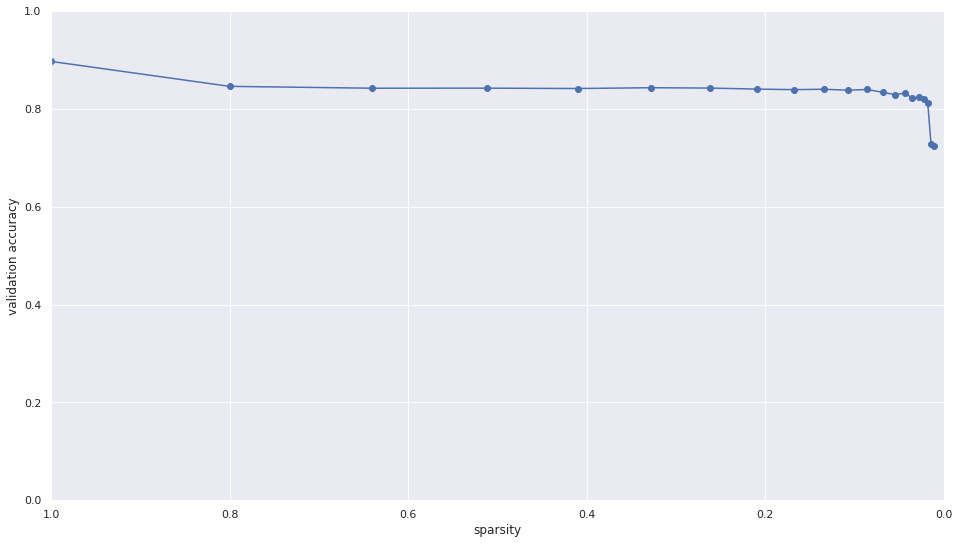

In [ ]:
#plotting sparsity vs accuracy
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0,1)
plt.xlabel("sparsity")
plt.ylabel("validation accuracy")
plt.scatter(sparsity_wr,best_acc_cpu_wr)
plt.plot(sparsity_wr,best_acc_list_wr)

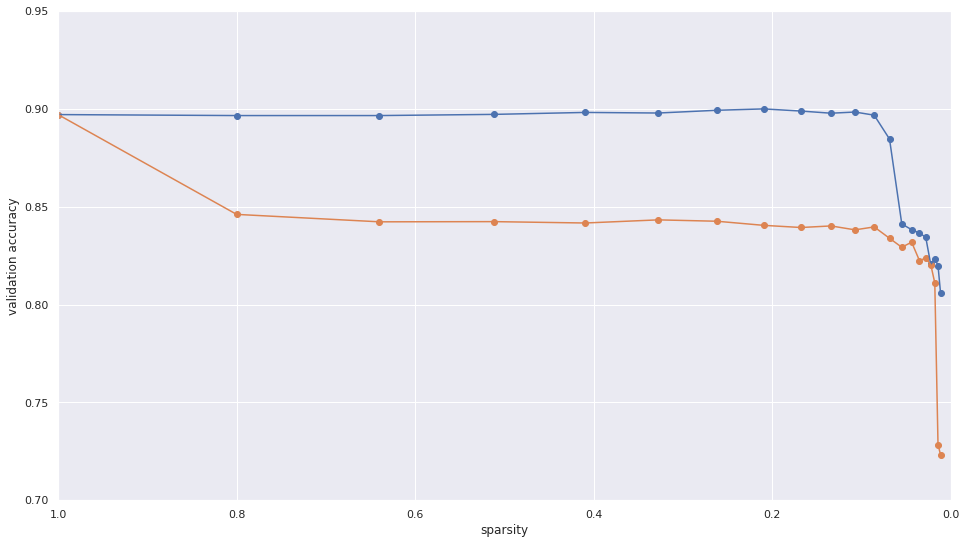

In [ ]:
#comparing acc of random reinit vs lottery ticket based init
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(0.7,0.95)
plt.xlabel("sparsity")
plt.ylabel("validation accuracy")
plt.scatter(sparsity,best_acc_cpu)
plt.plot(sparsity,best_acc_list)
plt.scatter(sparsity_wr,best_acc_cpu_wr)
plt.plot(sparsity_wr,best_acc_list_wr)

In [ ]:
sparsity_wr,best_acc_cpu_wr,early_stop_list_wr

([1,
  0.8,
  0.6400000000000001,
  0.5120000000000001,
  0.4096000000000001,
  0.3276800000000001,
  0.2621440000000001,
  0.20971520000000007,
  0.1677721600000001,
  0.13421772800000006,
  0.10737418240000006,
  0.08589934592000005,
  0.06871947673600004,
  0.054975581388800036,
  0.043980465111040035,
  0.03518437208883203,
  0.028147497671065624,
  0.022517998136852502,
  0.018014398509482003,
  0.014411518807585602,
  0.011529215046068483],
 [0.8971,
  tensor(0.8461),
  tensor(0.8423),
  tensor(0.8424),
  tensor(0.8417),
  tensor(0.8433),
  tensor(0.8426),
  tensor(0.8405),
  tensor(0.8394),
  tensor(0.8402),
  tensor(0.8382),
  tensor(0.8397),
  tensor(0.8339),
  tensor(0.8293),
  tensor(0.8319),
  tensor(0.8225),
  tensor(0.8238),
  tensor(0.8204),
  tensor(0.8111),
  tensor(0.7285),
  tensor(0.7232)],
 [52,
  58,
  51,
  58,
  45,
  59,
  57,
  55,
  51,
  59,
  52,
  59,
  56,
  55,
  56,
  59,
  56,
  56,
  58,
  59,
  58])

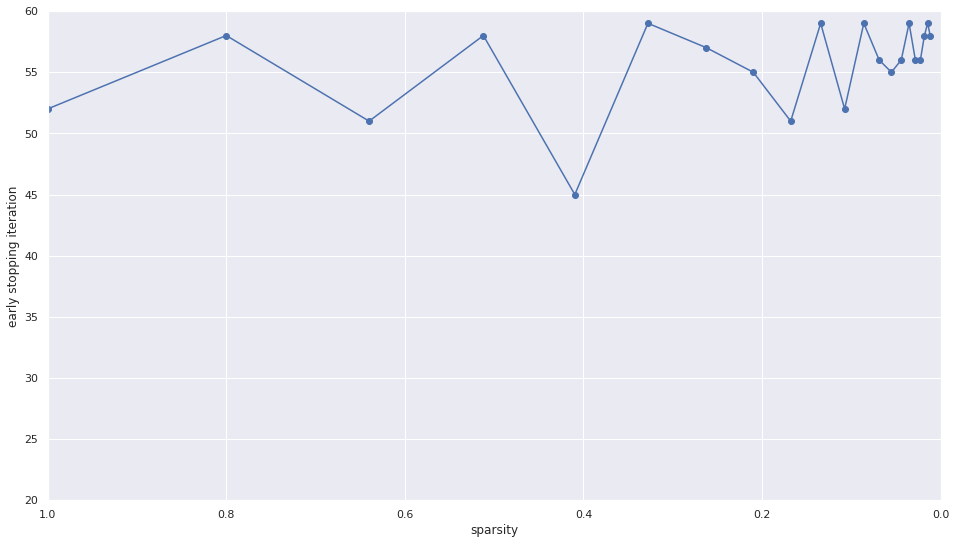

In [ ]:
#plotting early stopping vs sparsity
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(20,60)
plt.xlabel("sparsity")
plt.ylabel("early stopping iteration")
plt.scatter(sparsity_wr,early_stop_list_wr)
plt.plot(sparsity_wr,early_stop_list_wr)

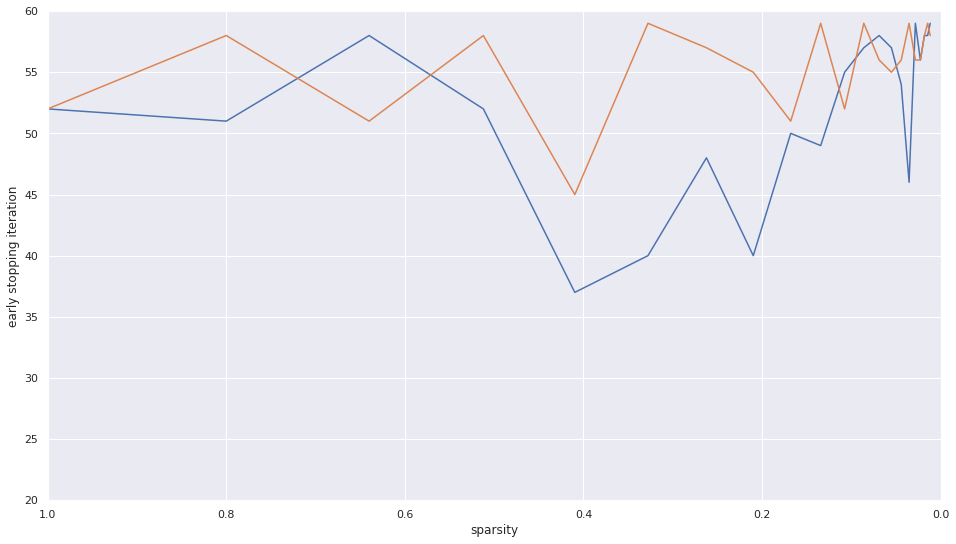

In [ ]:
#comparing early stopping iterations for random reinit and lottery ticket based
plt.figure(figsize=(16,9))
plt.xlim(1,0)
plt.ylim(20,60)
plt.xlabel("sparsity")
plt.ylabel("early stopping iteration")
#plt.scatter(sparsity,early_stop_list)
plt.plot(sparsity,early_stop_list)
#plt.scatter(sparsity_wr,early_stop_list_wr)
plt.plot(sparsity_wr,early_stop_list_wr)